# A Recurrent Network Mechanism of Time Integration in Perceptual Decisions
Wong,  Wang
Journal of Neuroscience, January 2006, 26(4):1212-1328

## Material and Methods
### The two-variable network model

### Calling Library Fuctions

In [1]:
# LIBRARY

import numpy as np # vector manipulation
import math  # math functions
import sys

# THIS IS FOR PLOTTING
%matplotlib inline
import matplotlib.pyplot as plt # side-stepping mpl backend
import warnings
warnings.filterwarnings("ignore")


### The Reduced Network Model

In [2]:
def H(x):
    a=270 # Hz/nA
    b=108 # Hz
    d=.154 # seconds
    f=(a*x-b)/(1-np.exp(-d*(a*x-b)))
    return f
x=np.arange(-1,1,0.01)


### Neural Circuit
$$ x_{1}=J_{11}S_1-J_{12}S_2+I_{0}+I_{1}+I_{noise,1}$$
$$ x_{2}=J_{22}S_2-J_{21}S_1+I_{0}+I_{2}+I_{noise,1}$$

where the synaptic couplings are $J_{11}=0.2609$, $J_{22}=0.2609$, $J_{12}=0.0497$ and $J_{21}=0.0497$.
$I_{0}=0.3255 nA$ represents external input 


In [3]:
def total_synaptic_current(S_1,S_2,I_1,I_2,I_noise_1,I_noise_2):
    # Synaptic coupling
    J_11=0.2609 # nA
    J_22=0.2609 # nA
    J_12=0.0497 # nA
    J_21=0.0497 # nA
    I_0=0.3255  # nA
    x_1=J_11*S_1-J_12*S_2+I_0+I_1+I_noise_1
    x_2=J_22*S_2-J_21*S_1+I_0+I_2+I_noise_2
    return x_1, x_2


### Background activity
$$ \tau_{AMPA}\frac{d I_{noise,i}(t)}{dt} =-I_{noise,i}(t)+\eta_i(t)\sqrt{\tau_{AMPA}}\sigma_{noise}$$

In [4]:
def Background_Activity(I_noise):
    h=0.1
    sigma_noise=0.02 # nA
    tau_AMPA=2 #ms
    eta_noise=np.random.normal(0,1,1)
    k=0#(-(I_noise)+eta_noise*np.sqrt(tau_AMPA)*sigma_noise)
    I_noise_new=I_noise+h/tau_AMPA*(-(I_noise+h/2*k)+eta_noise
                                *np.sqrt(tau_AMPA)*sigma_noise)
    return I_noise_new

### Network Dynamics
$$ \frac{d S_{i}}{dt} =-\frac{S_{i}}{\tau_S}+(1-S_{i})\gamma H_{i}$$

In [5]:
def Network_Dynamics(S,x):
    h=0.1/1000 #ms
    gamma=0.641
    tau_S=.09#100 #s
    k=(-S/tau_S+(1-S)*gamma*H(x)/1)
    S_new=S+h*(-(S+h/2*k)/tau_S+(1-S+h/2*k)*gamma*H(x))
    return S_new

### Input Current Target

$$ I_i=J_{A,ext}\mu_0\left(1+ \frac{c'}{100} \right) $$


In [6]:
def I_input_1(c_dash):
    J_A_ext=5.2/10000 # nA/Hz
    mu_0=30 # Hz
    I_motion=J_A_ext*mu_0*(1+(c_dash)/100)
    return I_motion

$$ I_2=J_{A,ext}\mu_0\left(1- \frac{c'}{100} \right) $$

In [7]:
def I_input_2(c_dash):
    J_A_ext=5.2/10000  # nA/Hz
    mu_0=30 # Hz
    I_motion=J_A_ext*mu_0*(1-(c_dash)/100)
    return I_motion

In [8]:
h=0.1
time=np.arange(-100,1000,h)
J_A_ext=0.00052 # nA/Hz
mu_0=30 # Hz
Vector_coherence=[1.0,3.0,5.0,7.5,10.0,15.0]
#Vector_coherence=[1.0,3.0,5.0]
Vector_coherence=[-10.0,-5.0,-3.0,-1.0,1.0,3.0,5.0,10.0]

Threshold=15
N=1000
RT_coh_hit=np.zeros(len(Vector_coherence))
RT_coh_miss=np.zeros(len(Vector_coherence))
Prob=np.zeros(len(Vector_coherence))
count=0
#fig = plt.figure(figsize=(12,8))

ALL_F_1=0.2*np.ones((N,len(time)))
ALL_F_2=0.2*np.ones((N,len(time)))
I_1=0.0*np.ones(len(time)) # np.zeros((1,len(time)))
I_2=0.0*np.ones(len(time)) # np.zeros((1,len(time)))
Firing_target_1=0*time # np.zeros((1,len(time)))
Firing_target_2=0*time # np.zeros((1,len(time)))




for j in range(0,len(Vector_coherence)):
    ANSWER=np.zeros(N)
    RT=np.zeros(N)


    for n in range(0,N):
        if n%500==0:
               print('Heading= %2.2f , n= %d' %(Vector_coherence[j],n))
        I_noise_1=0.001*np.random.normal(0,1,len(time))
        I_noise_2=0.001*np.random.normal(0,1,len(time))

        x_1=J_A_ext*mu_0*np.random.uniform(0,1,len(time))
        x_2=J_A_ext*mu_0*np.random.uniform(0,1,len(time))

        S_1=0.2*np.ones(len(time))+0.01*np.random.normal(0,1,len(time))#0.1*np.random.uniform(0,1,len(time))# np.random.normal(0,1,len(time))*0.0004
        S_2=0.2*np.ones(len(time))+0.01*np.random.normal(0,1,len(time)) #0.1*np.random.uniform(0,1,len(time)) #np.random.normal(0,1,len(time))*0.0004

 

        Firing_target_1[0]=H(x_1[0])
        Firing_target_2[0]=H(x_2[0])


        count=0
        for i in range (0,len(time)-1):
            if time[i] >=0 and time[i]<1000:
                c_dash=Vector_coherence[j]
            else:
                c_dash=0.0

        
            I_noise_1[i+1]=Background_Activity(I_noise_1[i])
            I_noise_2[i+1]=Background_Activity(I_noise_2[i])

            I_1[i+1]=I_input_1(c_dash)
            I_2[i+1]=I_input_1(-c_dash)

            x_1[i+1],x_2[i+1]=total_synaptic_current(S_1[i],S_2[i],I_1[i],I_2[i],I_noise_1[i],I_noise_2[i])
            S_1[i+1]=Network_Dynamics(S_1[i],x_1[i+1])
            S_2[i+1]=Network_Dynamics(S_2[i],x_2[i+1])
            Firing_target_1[i]=H(x_1[i])
            Firing_target_2[i]=H(x_2[i])


            if count <0.5:
                if Firing_target_1[i] >=Threshold: 
                    ANSWER[n]=1
                    RT[n]=time[i]
                    count=1
                elif Firing_target_2[i] >=Threshold:
                    ANSWER[n]=0
                    RT[n]=time[i]
                    count=1
                    
    
    RT_coh_hit[j]=np.average(RT[ANSWER==1])
    RT_coh_miss[j]=np.average(RT[ANSWER==0])
    Prob[j]=np.average(ANSWER)
    RT_coh_hit[j]=np.average(RT[ANSWER==1])
    RT_coh_miss[j]=np.average(RT[ANSWER==0])
    Prob[j]=np.average(ANSWER)


Heading= -10.00 , n= 0
Heading= -10.00 , n= 500
Heading= -5.00 , n= 0
Heading= -5.00 , n= 500
Heading= -3.00 , n= 0
Heading= -3.00 , n= 500
Heading= -1.00 , n= 0
Heading= -1.00 , n= 500
Heading= 1.00 , n= 0
Heading= 1.00 , n= 500
Heading= 3.00 , n= 0
Heading= 3.00 , n= 500
Heading= 5.00 , n= 0
Heading= 5.00 , n= 500
Heading= 10.00 , n= 0
Heading= 10.00 , n= 500


### Plotting
#### Input

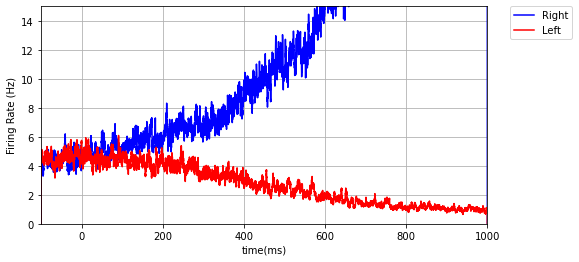

In [9]:
fig = plt.figure(figsize=(8,4))

plt.plot(time,Firing_target_1,'-',color='blue',label="Right")
plt.plot(time,Firing_target_2,'-',color='red',label="Left")
plt.grid()
plt.xlabel('time(ms)')
plt.ylabel('Firing Rate (Hz)')
plt.xlim((-100,1000))
plt.ylim((0,Threshold))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('Example_Firing_Pattern.png', bbox_inches='tight',dpi=300)

# plt.
#plt.ylim((30,50))
plt.show()


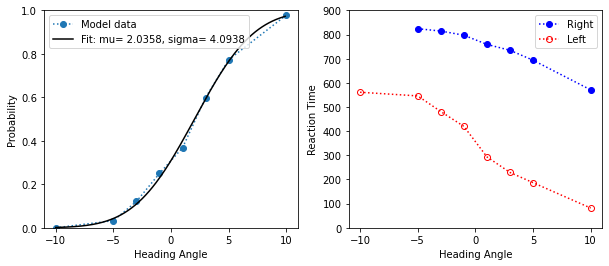

In [10]:
from scipy.optimize import curve_fit
from scipy.stats import norm


def func_temp(coh,alpha,beta):
    return 1-0.5*np.exp(-(coh/alpha)**beta)

#Vector_coh=[0.01,0.03,0.05,0.075,0.1,.15]
popr, pcov=curve_fit(func_temp,Prob,Vector_coherence)

mu,sigma=curve_fit(norm.cdf,Vector_coherence,Prob,p0=[0,1])[0]


fig = plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(Vector_coherence,Prob,'o:',label='Model data')
#Vector_coh=np.arange(np.min(Vector_coherence),np.max(Vector_coherence),0.1)
Vector_coh=np.arange(-10,10,0.1)

#plt.plot(Vector_coh*100,func_temp(Vector_coh,*popr),'k',label='Fit: a= %0.4f, b= %0.4f'% tuple(popr))
plt.plot(Vector_coh,norm.cdf(Vector_coh,mu,sigma),'k',label='Fit: mu= %2.4f, sigma= %2.4f'% (mu,sigma))

plt.legend()



plt.xlabel('Heading Angle')
plt.ylabel('Probability')
#plt.xscale('log')
plt.ylim(0,1)
plt.subplot(122)
plt.plot((Vector_coherence),RT_coh_hit,'o:',color='blue',label="Right")
plt.plot((Vector_coherence),RT_coh_miss,'o:',fillstyle='none',color='red',label="Left")
#plt.xscale('log')
plt.legend()
plt.ylim(0,900)
plt.xlabel('Heading Angle')
plt.ylabel('Reaction Time')
plt.savefig('Visual Heading Behavioural.png', bbox_inches='tight',dpi=300)
plt.show()

In [11]:
from scipy.optimize import curve_fit
from scipy.stats import norm
def func_temp(coh,alpha,beta):
    return 1-0.5*np.exp(-(coh/alpha)**beta)

#Vector_coh=[0.01,0.03,0.05,0.075,0.1,.15]
popr, pcov=curve_fit(func_temp,Prob,Vector_coherence)

In [12]:
popr

array([ 0.3519457 , 44.99979151])

(array([ 20.,   0.,   0.,  44., 218., 349., 225.,  85.,  40.,  19.]),
 array([  0. ,  98.8, 197.6, 296.4, 395.2, 494. , 592.8, 691.6, 790.4,
        889.2, 988. ]),
 <BarContainer object of 10 artists>)

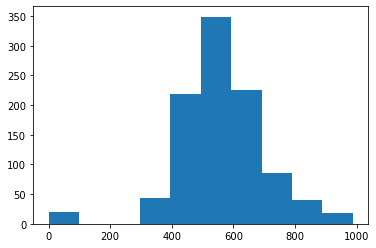

In [13]:
plt.hist(RT)

In [14]:
Vector_coherence[1]

-5.0

In [15]:
mu,sigma=curve_fit(norm.cdf,Vector_coherence,Prob,p0=[0,1])[0]



In [16]:
mu

2.035769535558214

In [17]:
sigma

4.093792934701982

In [18]:
Vector_coherence

[-10.0, -5.0, -3.0, -1.0, 1.0, 3.0, 5.0, 10.0]

In [19]:
np.min(Vector_coherence)

-10.0

In [20]:
np.max(Vector_coherence)

10.0